# Setup

In [1]:
import time
import tenseal as ts

POLY_MODULUS_DEGREE = 4096 * 2
#POLY_MODULUS_DEGREE = 16384
# Setup TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.BFV,
    poly_modulus_degree=POLY_MODULUS_DEGREE,
    plain_modulus=536903681
)
context.generate_galois_keys()

In [2]:
# Helper functions
def encrypt_value(value):
    encrypted_value = ts.bfv_vector(context, [value])
    return encrypted_value

def decrypt_value(encrypted_value):
    decrypted_value = encrypted_value.decrypt()
    return decrypted_value[0]

In [3]:
vector = [i for i in range(4096)]
encrypted_vector = ts.bfv_vector(context, vector)
serialized = encrypted_vector.serialize()
size = len(serialized)
size_per_element = size/1000
print(f"Size of the encrypted vecotor: {size/8/1024} KB")
print(f"Size per element: {size_per_element} bytes")


Size of the encrypted vecotor: 52.8001708984375 KB
Size per element: 432.539 bytes


# Computation

In [4]:
def calculate_encrypted_sum_single(vector):
    encrypted_sum = encrypt_value(0)
    for value in vector:
        encrypted_value = encrypt_value(value)
        encrypted_sum += encrypted_value
    return encrypted_sum

vector = [i for i in range(10)]
encrypted_sum = calculate_encrypted_sum_single(vector)
decrypted_sum = decrypt_value(encrypted_sum)
print(f"Encrypted sum: {decrypted_sum}")

Encrypted sum: 45


In [5]:
def calculate_encrypted_sum(vector):
    """
    This function works for vectors of any size
    :param vector:
    :return:
    """
    encrypted_vector = ts.bfv_vector(context, vector)
    encrypted_sum = encrypted_vector.sum()
    return encrypted_sum

In [6]:
import time

NUMBER_OF_ELEMENTS = 1750

vector = [i for i in range(NUMBER_OF_ELEMENTS)]
print(f"Vectorsum: {sum(vector)}")
start = time.perf_counter_ns()

encrypted_vector = ts.bfv_vector(context, vector)
encrypted_sum = encrypted_vector.sum()

decrypted_sum = encrypted_sum.decrypt()

stop = time.perf_counter_ns()
print(f"Time: {(stop-start)/1e6} ms")

decrypted_sum

Vectorsum: 1530375
Time: 121.675 ms


[1530375]

In [7]:
# Test the same performance with a same size vector using numpy
import numpy as np

vector = np.arange(NUMBER_OF_ELEMENTS)
start = time.perf_counter_ns()
sum_vector = np.sum(vector)
stop = time.perf_counter_ns()
print(f"Time: {(stop-start)/1e6} ms")
sum_vector



Time: 0.1149 ms


1530375

In [8]:
# test the performance of the encryption vs the numpy sum
# go from 100 to 100000 elements
# plot the time taken for each
import matplotlib.pyplot as plt

times_numpy = []
times_tenseal = []
times_tenseal_single = []
times_tenseal_encrypt = []
times_tenseal_decrypt = []

START = 100
NUMBER_OF_ELEMENTS = 2100
STEPS = 100

for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    print(f"Calculating for {i} elements")
    vector = np.arange(i)
    times_temp = []
    for j in range(1000):
        
        start = time.perf_counter_ns()
        sum_vector = np.sum(vector)
        stop = time.perf_counter_ns()
        times_temp.append((stop-start)/1e6)
    times_numpy.append(sum(times_temp)/len(times_temp))
    
    #print(f"Done with numpy")
    
    times_temp.clear()
    times_temp_encrypt = []
    times_temp_decrypt = []
    for j in range(100):
        start = time.perf_counter_ns()
        encrypted_vector = ts.bfv_vector(context, vector)
        times_temp_encrypt.append((time.perf_counter_ns()-start)/1e6)
        
        # Sum the encrypted vector elements
        start = time.perf_counter_ns()
        encrypted_sum = encrypted_vector.sum()
        times_temp.append((time.perf_counter_ns()-start)/1e6)
        
        # Decrypt the sum
        start = time.perf_counter_ns()
        decrypted_sum = encrypted_sum.decrypt()
        times_temp_decrypt.append((time.perf_counter_ns()-start)/1e6)
    
    # times_tenseal.append(sum(times_temp)/len(times_temp))
    # times_tenseal_encrypt.append(sum(times_temp_encrypt)/len(times_temp_encrypt))
    # times_tenseal_decrypt.append(sum(times_temp_decrypt)/len(times_temp_decrypt))
    
    # use median instead of mean
    times_tenseal.append(np.median(times_temp))
    times_tenseal_encrypt.append(np.median(times_temp_encrypt))
    times_tenseal_decrypt.append(np.median(times_temp_decrypt))
    
    # print(f"Done with tenseal")
    """
    times_temp.clear()
    for j in range(100):
        start = time.perf_counter_ns()
        encrypted_sum = calculate_encrypted_sum_single(vector)
        decrypted_sum = decrypt_value(encrypted_sum)
        stop = time.perf_counter_ns()
        times_temp.append((stop-start)/1e6)
    times_tenseal_single.append(sum(times_temp)/len(times_temp))
    
    print(f"Done with tenseal single")
    
    print(f"Done with {i} elements")
    """


Calculating for 100 elements
Calculating for 200 elements
Calculating for 300 elements
Calculating for 400 elements
Calculating for 500 elements
Calculating for 600 elements
Calculating for 700 elements
Calculating for 800 elements
Calculating for 900 elements
Calculating for 1000 elements
Calculating for 1100 elements
Calculating for 1200 elements
Calculating for 1300 elements
Calculating for 1400 elements
Calculating for 1500 elements
Calculating for 1600 elements
Calculating for 1700 elements
Calculating for 1800 elements
Calculating for 1900 elements
Calculating for 2000 elements


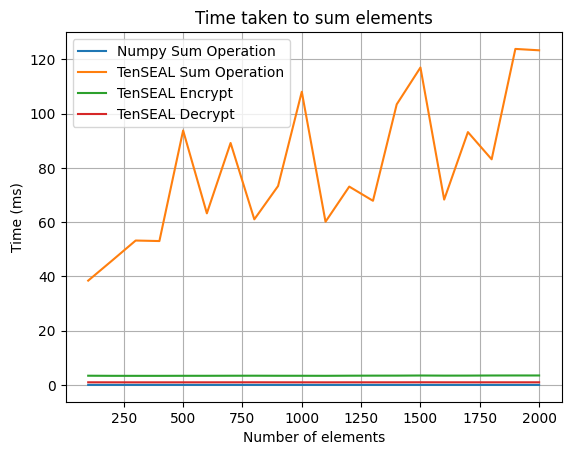

In [9]:
START = 100
NUMBER_OF_ELEMENTS = 2100
STEPS = 100

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken to sum elements")



plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_encrypt, label="TenSEAL Encrypt")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_decrypt, label="TenSEAL Decrypt")
# plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_single, label="TenSEAL Single")

# enable legend
plt.legend()

# Time difference between numpy and tenseal

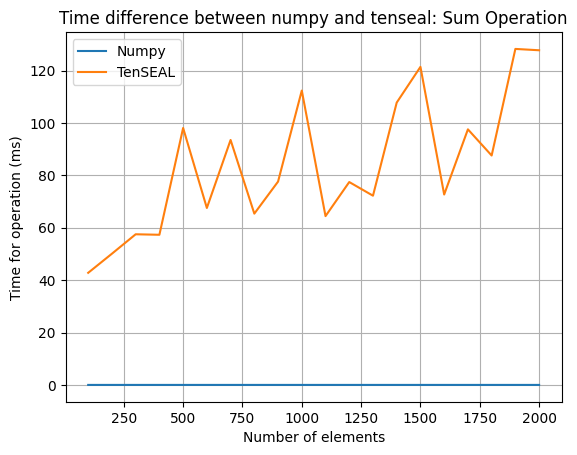

In [10]:
# only plot the time difference between numpy and tenseal and not the single sum

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time for operation (ms)")
plt.title("Time difference between numpy and tenseal: Sum Operation")
times_tenseal_sum = [tenseal + tenseal_decrypt + tenseal_encrypt for tenseal, tenseal_decrypt, tenseal_encrypt in zip(times_tenseal, times_tenseal_decrypt, times_tenseal_encrypt)]

#plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy")
plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_sum, label="TenSEAL")
plt.legend()

Average time difference: 83.960176985 ms


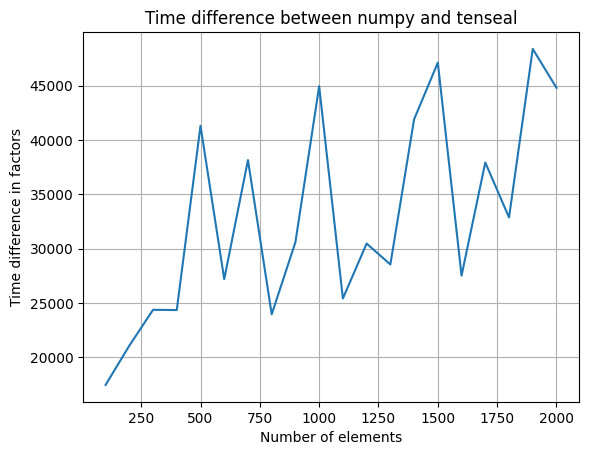

In [15]:
# calculate the average time difference

time_diff = [tenseal /numpy for numpy, tenseal in zip(times_numpy, times_tenseal_sum)]
time_diff_sub = [numpy - tenseal for numpy, tenseal in zip(times_numpy, times_tenseal_sum)]
avg_diff = abs(sum(time_diff_sub) / len(time_diff_sub))
print(f"Average time difference: {avg_diff} ms")

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference in factors")
plt.title("Time difference between numpy and tenseal")

plt.plot(range(100, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")


# Calculate bigger encrpyted Vectors by splitting them in equal chunks

- split the vector into smaller chunks
- encrypt the chunks
- sum the chunks
- sum the sums

In [16]:
def calculate_encrypted_sum_multiple(vector):
    """
    This functions doesn't work! cant compute on vectors of different sizes

    if the vector is too large, we can split it into smaller chunks
    and sum the chunks
    :param vector:
    :return:
    """
    divisor = int(POLY_MODULUS_DEGREE / 2) # this is the maximum size of the vector that can be encrypted
    #if len(vector) % divisor != 0:
    #    raise ValueError("The vector size must be a multiple of the divisor")

    sums = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i+divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_sum = encrypted_chunk.sum()
            sums.append(encrypted_sum)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_sum = encrypted_vector.sum()
        sums.append(encrypted_sum)
    
    # print(f"Number of blocks: {len(sums)}")

    encrypted_sum = sums[0]
    for s in sums[1:]:
        encrypted_sum += s

    decrypted_sum = encrypted_sum.decrypt()
    return decrypted_sum


vector = [1 for i in range(1700)]
s = sum(vector)
vector_sum = calculate_encrypted_sum_multiple(vector)
print(f"Encrypted sum: {vector_sum} / {sum(vector)}")

Encrypted sum: [1700] / 1700


In [17]:
def encrypt_vector_for_sum(vector: list) -> (list, int):
    """
    Encrypt the vector, if the vector is too large, we can split it into smaller chunks and return the encrypted chunks
    and number of chunks
    :Note: This only works for sum operations because the resulting vectors can be of different sizes
    :param vector:
    :return:
    """
    divisor = int(POLY_MODULUS_DEGREE / 2)  # the divisor splits the vector into smaller chunks to be encrypted,
    encrypted_chunks = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i + divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_chunks.append(encrypted_chunk)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_chunks.append(encrypted_vector)

    return encrypted_chunks, len(vector)


def sum_encrypted_vector(encrypted_vectors: list[ts.bfv_vector]) -> ts.bfv_vector:
    encrypted_sum = encrypted_vectors[0].sum()
    for s in encrypted_vectors[1:]:
        encrypted_sum += s.sum()
    return encrypted_sum



In [18]:
vector = [1 for i in range(10000)]
encrypted_chunks, num_elements = encrypt_vector_for_sum(vector)
encrypted_sum = sum_encrypted_vector(encrypted_chunks)
decrypted_sum = encrypted_sum.decrypt()
print(f"Encrypted sum: {decrypted_sum} Expected: {sum(vector)}")

Encrypted sum: [10000] Expected: 10000


In [19]:
import matplotlib.pyplot as plt

times_numpy = []
times_tenseal = []
times_tenseal_encrypt = []
times_tenseal_decrypt = []

START = 2000
NUMBER_OF_ELEMENTS = 20000
STEPS = 2000

for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    vector = [1 for i in range(i)]
    arr = np.ones(i)
    
    times_temp = []
    for j in range(1000):
        start = time.perf_counter_ns()
        sum_vector = np.sum(arr)
        stop = time.perf_counter_ns()
        times_temp.append((stop-start)/1e6)
    times_numpy.append(sum(times_temp)/len(times_temp))
    
    print(f"Done with numpy")
    
    times_temp.clear()
    times_temp_encrypt = []
    times_temp_decrypt = []
    for j in range(100):
        start = time.perf_counter_ns()
        encrypted_chunks, _ = encrypt_vector_for_sum(vector)
        times_temp_encrypt.append((time.perf_counter_ns()-start)/1e6)
        
        start = time.perf_counter_ns()
        encrypted_sum = sum_encrypted_vector(encrypted_chunks)
        times_temp.append((time.perf_counter_ns()-start)/1e6)
        
        start = time.perf_counter_ns()
        decrypted_sum = encrypted_sum.decrypt()
        times_temp_decrypt.append((time.perf_counter_ns()-start)/1e6)
    
    # times_tenseal.append(sum(times_temp)/len(times_temp))
    # times_tenseal_encrypt.append(sum(times_temp_encrypt)/len(times_temp_encrypt))
    # times_tenseal_decrypt.append(sum(times_temp_decrypt)/len(times_temp_decrypt))
    # use median instead of mean
    times_tenseal.append(np.median(times_temp))
    times_tenseal_encrypt.append(np.median(times_temp_encrypt))
    times_tenseal_decrypt.append(np.median(times_temp_decrypt))
    
    print(f"Done with {i} elements")


Done with numpy
Done with 2000 elements
Done with numpy
Done with 4000 elements
Done with numpy
Done with 6000 elements
Done with numpy
Done with 8000 elements
Done with numpy
Done with 10000 elements
Done with numpy
Done with 12000 elements
Done with numpy
Done with 14000 elements
Done with numpy
Done with 16000 elements
Done with numpy
Done with 18000 elements


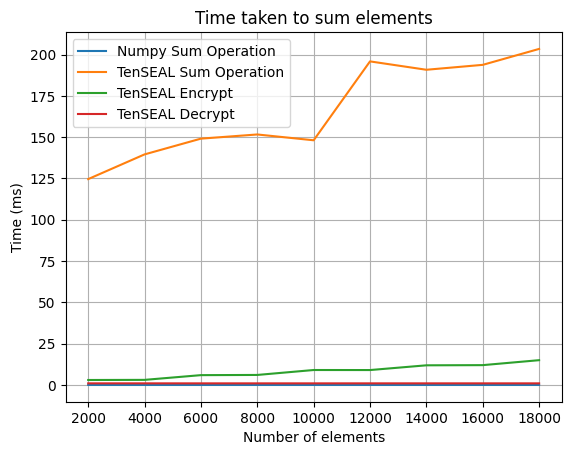

In [20]:
# plot the time difference between numpy and tenseal
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken to sum elements")


plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_numpy, label="Numpy Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal, label="TenSEAL Sum Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_encrypt, label="TenSEAL Encrypt")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times_tenseal_decrypt, label="TenSEAL Decrypt")

# enable legend
plt.legend()

In [21]:
times_tenseal_sum = [tenseal + tenseal_decrypt + tenseal_encrypt for tenseal, tenseal_decrypt, tenseal_encrypt in zip(times_tenseal, times_tenseal_decrypt, times_tenseal_encrypt)]
print(f"Time numpy                 min: {min(times_numpy)} max: {max(times_numpy)}")
print(f"Time tenseal sum operation min: {min(times_tenseal)} max: {max(times_tenseal)}")
print(f"Time tenseal encrypt       min: {min(times_tenseal_encrypt)} max: {max(times_tenseal_encrypt)}")
print(f"Time max tenseal decrypt   min: {min(times_tenseal_decrypt)} max: {max(times_tenseal_decrypt)}")
print(f"Time max tenseal total     min {min(times_tenseal_sum)} max: {max(times_tenseal_sum)}")
times_numpy_avg = sum(times_numpy)/len(times_numpy)
print(f"max factor: {times_tenseal_sum[-1]/times_numpy_avg}")

Time numpy                 min: 0.0029095999999999692 max: 0.0057189999999999646
Time tenseal sum operation min: 124.62785 max: 203.44029999999998
Time tenseal encrypt       min: 2.98475 max: 14.9834
Time max tenseal decrypt   min: 0.94275 max: 0.9576
Time max tenseal total     min 128.5702 max: 219.37084999999996
max factor: 49320.95732243501


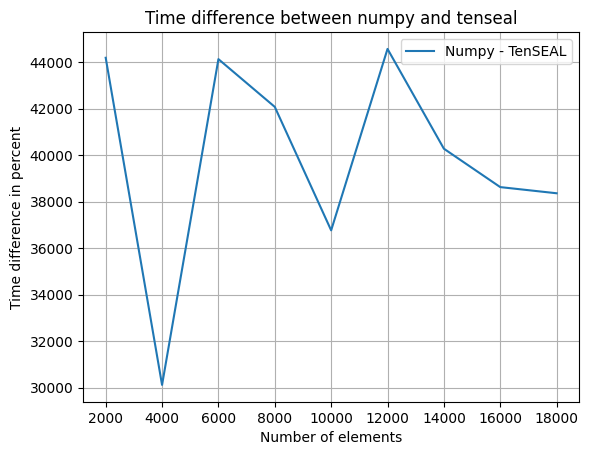

In [22]:
import matplotlib.pyplot as plt

# plot the time difference between numpy and tenseal
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference in percent")
plt.title("Time difference between numpy and tenseal")

time_diff = [tenseal / numpy for numpy, tenseal in zip(times_numpy, times_tenseal_sum)]
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.legend()

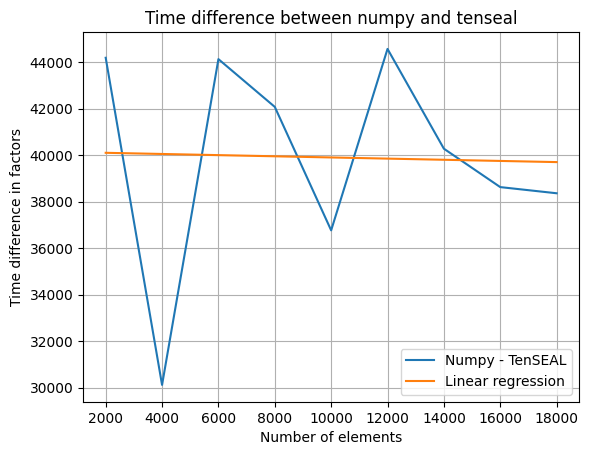

In [23]:
# linear regression to draw a line through the data
from sklearn.linear_model import LinearRegression

X = np.array(range(START, NUMBER_OF_ELEMENTS, STEPS)).reshape(-1, 1)

reg = LinearRegression().fit(X, time_diff)
reg.score(X, time_diff)

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference in factors")
plt.title("Time difference between numpy and tenseal")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.plot(X, reg.predict(X), label="Linear regression")
plt.legend()

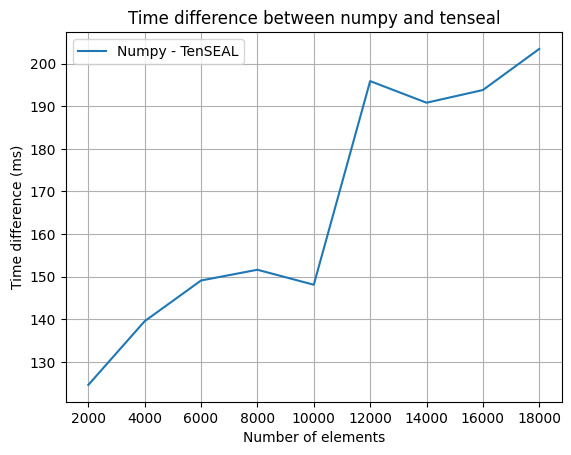

In [24]:
# plot the time difference between numpy and tenseal
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time difference (ms)")
plt.title("Time difference between numpy and tenseal")
z = list(zip(times_numpy, times_tenseal))
time_diff = [tenseal - numpy for numpy, tenseal in zip(times_numpy, times_tenseal)]
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), time_diff, label="Numpy - TenSEAL")
plt.legend()



# Tenseal other operations

In [25]:
def sum_encrypted_vector(encrypted_vectors: list[ts.bfv_vector], scalar: int) -> ts.bfv_vector:
    encrypted_sum = encrypted_vectors[0].sum()
    for s in encrypted_vectors[1:]:
        encrypted_sum += s.sum()
    return encrypted_sum

def multiply_scalar_encrypted_vector(encrypted_vectors: list[ts.bfv_vector], scalar: int) -> ts.bfv_vector:
    for v in encrypted_vectors:
        v *= scalar
    return encrypted_vectors
    

def add_scalar_encrypted_vector(encrypted_vectors: list[ts.bfv_vector], scalar: int) -> ts.bfv_vector:
    for v in encrypted_vectors:
        v += scalar
    return encrypted_vectors

def subtract_scalar_encrypted_vector(encrypted_vectors: list[ts.bfv_vector], scalar: int) -> ts.bfv_vector:
    add_scalar_encrypted_vector(encrypted_vectors, -scalar)
    
def power_encrypted_vector(encrypted_vectors: list[ts.bfv_vector], power: int) -> ts.bfv_vector:
    for v in encrypted_vectors:
        v *= v
    return encrypted_vectors


In [26]:
import numpy as np
import copy
START = 10000
NUMBER_OF_ELEMENTS = 100000
STEPS = 10000

tenseal_operation_times = {}
for operation in [sum_encrypted_vector, multiply_scalar_encrypted_vector, add_scalar_encrypted_vector, subtract_scalar_encrypted_vector, power_encrypted_vector]:
    if operation not in tenseal_operation_times:
        tenseal_operation_times[operation.__name__] = []
    print(f"Calculating for {operation.__name__}")
    
    for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
        vector = [1 for i in range(i)]
        encrypted_vector, _ = encrypt_vector_for_sum(vector)
        times_temp = []
        for j in range(50): # repeat the operation to get a better average
            copy = encrypted_vector.copy()
            start = time.perf_counter_ns()
            result = operation(copy, 2)
            stop = time.perf_counter_ns()
            times_temp.append((stop-start)/1e6)
        tenseal_operation_times[operation.__name__].append(np.median(times_temp))
        print(f"Done with {operation.__name__} for {i} elements")
        


Calculating for sum_encrypted_vector
Done with sum_encrypted_vector for 10000 elements
Done with sum_encrypted_vector for 20000 elements
Done with sum_encrypted_vector for 30000 elements
Done with sum_encrypted_vector for 40000 elements
Done with sum_encrypted_vector for 50000 elements
Done with sum_encrypted_vector for 60000 elements
Done with sum_encrypted_vector for 70000 elements
Done with sum_encrypted_vector for 80000 elements
Done with sum_encrypted_vector for 90000 elements
Calculating for multiply_scalar_encrypted_vector
Done with multiply_scalar_encrypted_vector for 10000 elements
Done with multiply_scalar_encrypted_vector for 20000 elements
Done with multiply_scalar_encrypted_vector for 30000 elements
Done with multiply_scalar_encrypted_vector for 40000 elements
Done with multiply_scalar_encrypted_vector for 50000 elements
Done with multiply_scalar_encrypted_vector for 60000 elements
Done with multiply_scalar_encrypted_vector for 70000 elements
Done with multiply_scalar_encr

In [27]:
import numpy as np
import time

# Define operations as functions for NumPy arrays
def sum_vector(vector, scalar):
    return np.sum(vector)

def multiply_scalar_vector(vector, scalar):
    return np.multiply(vector, scalar)

def add_scalar_vector(vector, scalar):
    return np.add(vector, scalar)

def subtract_scalar_vector(vector, scalar):
    return np.subtract(vector, scalar)

def power_vector(vector, scalar):
    return np.power(vector, scalar)


START = 10000
NUMBER_OF_ELEMENTS = 100000
STEPS = 10000

numpy_operation_times = {}

# List of operations to be performed
operations = [sum_vector, multiply_scalar_vector, add_scalar_vector, subtract_scalar_vector, power_vector]

# Loop through each operation
for operation in operations:
    if operation.__name__ not in numpy_operation_times:
        numpy_operation_times[operation.__name__] = []
    print(f"Calculating for {operation.__name__}")
    
    for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
        vector = np.ones(i)  # Create a NumPy array with ones
        times_temp = []
        
        for j in range(50):  # repeat the operation to get a better average
            start = time.perf_counter_ns()
            result = operation(vector, 2)  # Perform the operation
            stop = time.perf_counter_ns()
            times_temp.append((stop - start) / 1e6)  # Time in milliseconds
        
        numpy_operation_times[operation.__name__].append(np.median(times_temp))  # Store median time
        print(f"Done with {operation.__name__} for {i} elements")

Calculating for sum_vector
Done with sum_vector for 10000 elements
Done with sum_vector for 20000 elements
Done with sum_vector for 30000 elements
Done with sum_vector for 40000 elements
Done with sum_vector for 50000 elements
Done with sum_vector for 60000 elements
Done with sum_vector for 70000 elements
Done with sum_vector for 80000 elements
Done with sum_vector for 90000 elements
Calculating for multiply_scalar_vector
Done with multiply_scalar_vector for 10000 elements
Done with multiply_scalar_vector for 20000 elements
Done with multiply_scalar_vector for 30000 elements
Done with multiply_scalar_vector for 40000 elements
Done with multiply_scalar_vector for 50000 elements
Done with multiply_scalar_vector for 60000 elements
Done with multiply_scalar_vector for 70000 elements
Done with multiply_scalar_vector for 80000 elements
Done with multiply_scalar_vector for 90000 elements
Calculating for add_scalar_vector
Done with add_scalar_vector for 10000 elements
Done with add_scalar_vect

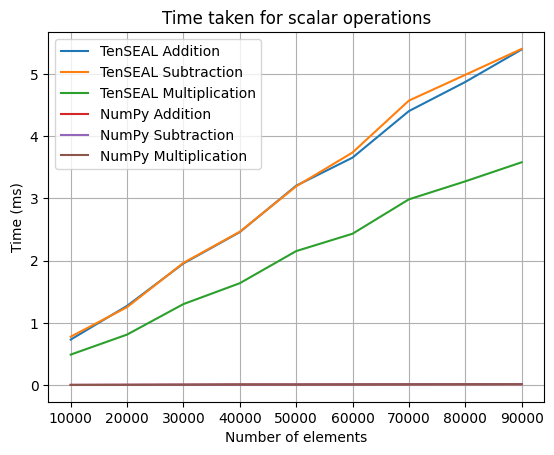

In [28]:
import matplotlib.pyplot as plt
# plot the times

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken for scalar operations")

translation = {
    "TenSEAL Addition": "add_scalar_encrypted_vector",
    "TenSEAL Subtraction": "subtract_scalar_encrypted_vector",
    "TenSEAL Multiplication": "multiply_scalar_encrypted_vector",
    "NumPy Addition": "add_scalar_vector",
    "NumPy Subtraction": "subtract_scalar_vector",
    "NumPy Multiplication": "multiply_scalar_vector",
}

combined_times = {**tenseal_operation_times, **numpy_operation_times}


for text, operation in translation.items():
    plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), combined_times[operation], label=text)
"""  
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), tenseal_operation_times["add_scalar_encrypted_vector"], label="Addition")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), tenseal_operation_times["subtract_scalar_encrypted_vector"], label="Subtraction")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), tenseal_operation_times["multiply_scalar_encrypted_vector"], label="Multiplication")

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), tenseal_operation_times["power_encrypted_vector"], label="Power")
"""  
"""
for operation, times in operation_times.items():
    if operation == "power_encrypted_vector" or operation == "sum_encrypted_vector":
        continue
    plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), times, label=operation)
"""  
plt.legend()

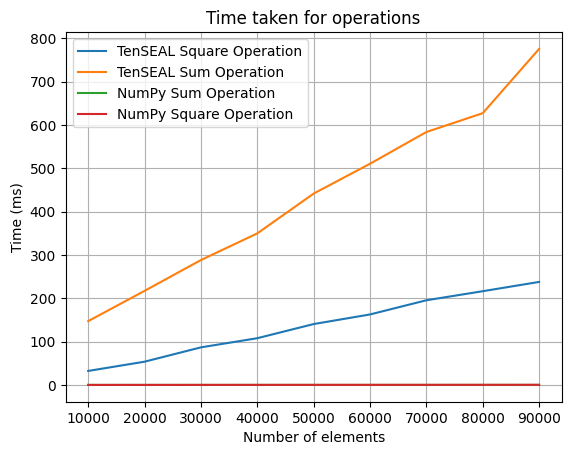

In [29]:
# plot the times

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Time (ms)")
plt.title("Time taken for operations")

translation = {
    "TenSEAL Square Operation": "power_encrypted_vector",
    "TenSEAL Sum Operation": "sum_encrypted_vector",
    "NumPy Sum Operation": "sum_vector",
    "NumPy Square Operation": "power_vector",
}
for text, operation in translation.items():
    plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), combined_times[operation], label=text)
    
"""
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), operation_times["power_encrypted_vector"], label="Square Operation")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), operation_times["sum_encrypted_vector"], label="Sum Operation")
""" 
plt.legend()

# Size Difference of plain vs encrypted data

In [ ]:
import base64

def encrypt_vector_batching(context, vector: list) -> (list, int):
    """
    Encrypt the vector, if the vector is too large, we can split it into smaller chunks and return the encrypted chunks
    and number of chunks
    :Note: This only works for sum operations because the resulting vectors can be of different sizes
    :param vector:
    :return:
    """
    print(f"Poly modulus degree: {POLY_MODULUS_DEGREE}")
    divisor = int(POLY_MODULUS_DEGREE / 2) + 20000  # the divisor splits the vector into smaller chunks to be encrypted,
    encrypted_chunks = []
    if len(vector) > divisor:
        for i in range(0, len(vector), divisor):
            chunk = vector[i:i + divisor]
            encrypted_chunk = ts.bfv_vector(context, chunk)
            encrypted_chunks.append(encrypted_chunk)
    else:
        encrypted_vector = ts.bfv_vector(context, vector)
        encrypted_chunks.append(encrypted_vector)

    return encrypted_chunks, len(vector)


def sum_encrypted_vector(encrypted_vectors: list[ts.bfv_vector]) -> ts.bfv_vector:
    encrypted_sum = encrypted_vectors[0].sum()
    for s in encrypted_vectors[1:]:
        encrypted_sum += s.sum()
    return encrypted_sum


def serialize_encrypted_vector(encrypted_vectors: ts.bfv_vector) -> str:
    """
    Serialize the encrypted vector to bytes and then to base64
    :param encrypted_vectors: encrypted vector
    :return: serialized encrypted vector
    """
    bytes = encrypted_vectors.serialize()
    serialized = base64.b64encode(bytes)
    string_data = serialized.decode('utf-8')
    return string_data


def serialize_encrypted_vectors(encrypted_vectors: list[ts.bfv_vector]) -> list[str]:
    """
    Serialize the encrypted vectors to bytes and then to base64
    :param encrypted_vectors: list of encrypted vectors
    :return: list of serialized encrypted vectors
    """
    serialized_vectors = []
    for v in encrypted_vectors:
        serialized = serialize_encrypted_vector(v)
        serialized_vectors.append(serialized)
    return serialized_vectors


def get_serialized_context(context):
    context_serialized = context.serialize(save_public_key=True, save_secret_key=False, save_galois_keys=True)
    context_encoded = base64.b64encode(context_serialized).decode('utf-8')
    return context_encoded


In [ ]:
for n in range(1000, 10000, 1000):
    arr = np.ones(n)
    vector = [1 for i in range(n)]
    
    encrypted_vectors, num_elements = encrypt_vector_batching(context, vector)
    serialized_vectors = serialize_encrypted_vectors(encrypted_vectors)
    size_phe = sum([len(s.encode('utf-8')) for s in serialized_vectors])
    print(f"Number of elements: {n}")
    print(f"Size of plain vector: {arr.nbytes/1024} KB")
    print(f"Size of the encrypted vecotor: {size_phe/1024} KB")
    print(f"Size of context: {len(get_serialized_context(context).encode('utf-8'))/1024/1024} MB")
    print("-----------")
    

In [ ]:
import matplotlib.pyplot as plt

sizes_plain = []
sizes_encrypted = []

START = 10000
NUMBER_OF_ELEMENTS = 500000
STEPS = 10000
print("Calculating sizes")
for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    print(f"Calculating for {i} elements")
    vector = [1 for i in range(i)]
    arr = np.ones(i)

    start = time.perf_counter_ns()
    size = arr.nbytes
    size_kb = size/1024
    size_mb = size_kb/1024
    stop = time.perf_counter_ns()
    sizes_plain.append(size_mb)

    #print(f"Done with numpy")

    start = time.perf_counter_ns()
    
    encrypted_vectors, num_elements = encrypt_vector_batching(context, vector)
    serialized_vectors = serialize_encrypted_vectors(encrypted_vectors)
    size = sum([len(s.encode('utf-8')) for s in serialized_vectors])
    size_kb = size/1024
    size_mb = size_kb/1024
    stop = time.perf_counter_ns()
    sizes_encrypted.append(size_mb)
    #print(f"Done with {i} elements")




In [ ]:
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Size (Mb)")
plt.title("Size of plain vs encrypted data")

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_plain, label="Plain")
plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_encrypted, label="Encrypted")

# enable legend
plt.legend()

In [ ]:
plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Size difference in factors")
plt.title("Size of plain vs encrypted data")

size_diff = [encrypted / plain for plain, encrypted in zip(sizes_plain, sizes_encrypted)]

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), size_diff, label="Encrypted")

# enable legend
plt.legend()

# Bigger Poly Modulus Degree

In [ ]:
import matplotlib.pyplot as plt

sizes_plain = []
sizes_encrypted = {}

START = 10000
NUMBER_OF_ELEMENTS = 500000
STEPS = 10000
print("Calculating sizes")

for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
    print(f"Calculating for {i} elements")
    arr = np.ones(i)
    size = arr.nbytes
    size_kb = size/1024
    size_mb = size_kb/1024
    sizes_plain.append(size_mb)
    

for poly in [4096, 8192, 16384]:
    print(f"Calculating for poly: {poly}")
    POLY_MODULUS_DEGREE = poly
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=POLY_MODULUS_DEGREE,
        plain_modulus=536903681
    )
    context.generate_galois_keys()
    for i in range(START, NUMBER_OF_ELEMENTS, STEPS):
        print(f"Calculating for {i} elements")
        vector = [1 for i in range(i)]
        encrypted_vectors, num_elements = encrypt_vector_batching(context, vector)
        serialized_vectors = serialize_encrypted_vectors(encrypted_vectors)
        size = sum([len(s.encode('utf-8')) for s in serialized_vectors])

        size_kb = size/1024
        size_mb = size_kb/1024

        
        #sizes_encrypted.setdefault(poly, []).append(size_mb)
        if poly not in sizes_encrypted:
            sizes_encrypted[poly] = []
        sizes_encrypted[poly].append(size_mb)
    
    #print(f"Done with {i} elements")


In [ ]:

plt.figure()
# enable the grid
plt.grid(True)
plt.xlabel("Number of elements")
plt.ylabel("Size (Mb)")
plt.title("Size of plain data vs encrypted data")

print(f"START: {START} NUMBER_OF_ELEMENTS: {NUMBER_OF_ELEMENTS} STEPS: {STEPS}")

plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_plain, label="Plain")

for poly, sizes in sizes_encrypted.items():
    print(f"Poly: {poly}")
    print(f"len: {len(sizes)}")
    plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes, label=f"Encrypted mod: {poly}")
#plt.plot(range(START, NUMBER_OF_ELEMENTS, STEPS), sizes_encrypted, label="Encrypted")

# enable legend
plt.legend()

# Context Size  

In [ ]:
for poly in [4096, 8192, 16384]:
    print(f"Calculating for poly: {poly}")
    POLY_MODULUS_DEGREE = poly
    context = ts.context(
        ts.SCHEME_TYPE.BFV,
        poly_modulus_degree=POLY_MODULUS_DEGREE,
        plain_modulus=536903681
    )
    context.generate_galois_keys()
    context_bytes_size = len(get_serialized_context(context).encode('utf-8'))
    print(f"Size of context: {context_bytes_size/1024/1024} MB")
